In [1]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib as plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from datetime import datetime

In [2]:
# Load Dataset

def load_data():
    geo_params = pd.read_csv('../Data/geo_params.csv')
    sales = pd.read_csv('../Data/sales.csv')
    sku = pd.read_csv('../Data/sku.csv')
    test = pd.read_csv('../Data/test.csv')
    
    
    ## Transform dataset
    
    sales['date'] = pd.to_datetime(sales['date']).dt.strftime('%Y%m%d').astype('float32')
    #sales['date'] = pd.to_datetime(sales['date'])
    #sales['date'] = sales['date'].astype(int)
    #sales['date'] = sales['date'].apply(lambda x: int(x))
    
    # Fill null values with 0
    sales['price'].fillna(0, inplace=True)
    sales['sales'].fillna(0, inplace=True)
    
    # Delete data above 90th percentil
    #sales = sales[sales['price'] < sales['price'].quantile(.95)]
    #sales = sales[sales['sales'] < sales['sales'].quantile(.95)]
    
    # Normalize data
    x = sales[['date', 'price', 'date']].values #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    sales[['date', 'price', 'date']] = pd.DataFrame(x_scaled)

    
    # sales[['date','price','sales']] = normalize(sales[['date','price','sales']])
    print(sales.describe().transpose())
    
    sku.dropna(subset = ['Category'], inplace=True)
    del sku['Units'] # Null field
    
    return geo_params, sales, sku, test

In [3]:
geo_params, sales, sku, test = load_data()

# Categories to train the model
Categories = sku['Category'].unique()
geoClusters = geo_params['geoCluster'].unique()

                count           mean            std   min           25%  \
geoCluster  4605985.0    2220.030811     245.924925  92.0   2049.000000   
SKU         4605985.0  367135.310983  300513.500537  24.0  39465.000000   
date        4605985.0       0.540246       0.448238   0.0      0.076952   
price       4605985.0       0.001574       0.005981   0.0      0.000000   
sales       4605985.0       0.607308       2.330636   0.0      0.000000   

                      50%            75%       max  
geoCluster    2158.000000    2269.000000    3230.0  
SKU         363713.000000  642700.000000  838137.0  
date             0.943795       0.972463       1.0  
price            0.000000       0.000000       1.0  
sales            0.000000       0.000000     801.0  


In [4]:
# Geo_params Headers

print(geo_params.head())

   geoCluster  cityId
0          21       1
1          47       1
2          48       1
3          92       1
4         112       1


In [5]:
# Sales Headers

print(sales.head())

           ID  geoCluster    SKU      date     price  sales
0  RR27956459          92  32485  1.000000  0.005284    4.0
1  RR27956474          92  32549  1.000000  0.012335    0.5
2  RR27956489         112  32485  0.983402  0.006263    3.7
3  RR27956490         112  32485  0.983402  0.000000    0.0
4  RR27956491         112  32485  0.983402  0.000000    0.0


In [6]:
# Sku Headers

print(sku.head())

     SKU                  Category  \
0     24               Pomegranate   
1    208          Water, sparkling   
2   1008  Water, import, sparkling   
3  16649              Water, still   
4  20872          Water, sparkling   

                                            Type  brandId  lagerUnitQuantity  \
0            Tropical fruit — Pomegranate— Plain      NaN                1.0   
1  Therapeutic-table water — PET — from 1 to 2 L   1241.0                1.5   
2       Therapeutic-table water — Import — Glass   1241.0                0.5   
3      Table water — PET — from 1 to 2 L — Still   1241.0                1.5   
4  Therapeutic-table water — PET — from 1 to 2 L   2693.0                1.5   

   trademark  countryOfOrigin            Group  
0        NaN              NaN  Tropical fruits  
1     3670.0              1.0    Mineral water  
2     4970.0             14.0    Mineral water  
3     1323.0              1.0    Mineral water  
4     4384.0              1.0    Mineral wate

In [7]:
# Test Headers

print(test.head())

           ID  geoCluster    SKU        date  price_filled  sales
0  RR27956447          21  32485  2021-07-08         39.69    NaN
1  RR27956448          21  32485  2021-07-09         39.69    NaN
2  RR27956449          21  32485  2021-07-10         39.69    NaN
3  RR27956450          21  32485  2021-07-11         39.69    NaN
4  RR27956451          21  32485  2021-07-12         39.69    NaN


In [8]:
# Merge table sales and sku

df = pd.merge(sales, sku, on='SKU', how='inner')
df.head()

,ID,geoCluster,SKU,date,price,sales,Category,Type,brandId,lagerUnitQuantity,trademark,countryOfOrigin,Group
0,RR27956459,92,32485,1.000000,0.005284,4.0,Banana,Banana — Plain,NaN,1.0,NaN,NaN,Tropical fruits
1,RR27956489,112,32485,0.983402,0.006263,3.7,Banana,Banana — Plain,NaN,1.0,NaN,NaN,Tropical fruits
2,RR27956490,112,32485,0.983402,0.000000,0.0,Banana,Banana — Plain,NaN,1.0,NaN,NaN,Tropical fruits
3,RR27956491,112,32485,0.983402,0.000000,0.0,Banana,Banana — Plain,NaN,1.0,NaN,NaN,Tropical fruits
4,RR27956492,112,32485,0.983591,0.000000,0.0,Banana,Banana — Plain,NaN,1.0,NaN,NaN,Tropical fruits


In [9]:
# Types of columns

print(df.dtypes)

ID                    object
geoCluster             int64
SKU                    int64
date                 float64
price                float64
sales                float64
Category              object
Type                  object
brandId              float64
lagerUnitQuantity    float64
trademark            float64
countryOfOrigin      float64
Group                 object
dtype: object


In [10]:
# Load train and test set

def load_sets(data):
    X = data[['date', 'price', 'geoCluster']].sort_values(by=['date', 'geoCluster']).copy()
    y = data[['sales']].copy()
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.1, shuffle=False)
    return trainX, trainY, testX, testY

<AxesSubplot:>

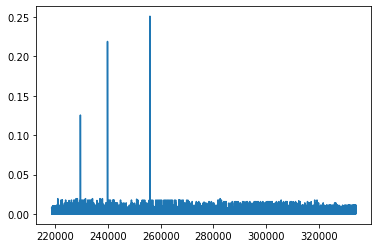

In [11]:
df['price'].loc[df['Category'] == 'Lemon'].plot()

<AxesSubplot:>

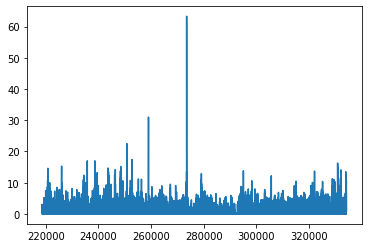

In [12]:
df['sales'].loc[df['Category'] == 'Lemon'].plot()

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
geoCluster,4121843.0,2220.864916,246.626276,92.0,2050.000000,2158.000000,2269.000000,3230.0
SKU,4121843.0,320003.957123,281188.046682,24.0,32550.000000,233272.000000,571258.000000,838137.0
date,4121843.0,0.544690,0.447954,0.0,0.076952,0.943983,0.972463,1.0
price,4121843.0,0.001648,0.006256,0.0,0.000000,0.000000,0.000000,1.0
sales,4121843.0,0.630283,2.413480,0.0,0.000000,0.000000,0.000000,801.0
brandId,2131067.0,3517.037445,2571.798615,1241.0,1330.000000,2737.000000,2737.000000,8314.0
lagerUnitQuantity,4121843.0,89.180218,148.311992,0.5,1.000000,1.000000,120.000000,550.0
trademark,3064130.0,6716.793651,4541.424014,297.0,2781.000000,5070.000000,9666.000000,15156.0
countryOfOrigin,2276373.0,7.333040,10.094390,1.0,1.000000,1.000000,14.000000,37.0


In [14]:
# Train 1 model for each category

models = {}

for category in Categories[1:2]:
    # create and fit the LSTM network
    
    data = df.loc[df['Category'] == category].iloc[:100, :]

    trainX, trainY, testX, testY = load_sets(data)
    #trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    trainX = np.expand_dims(trainX, axis=-1)
    testX = np.expand_dims(testX, axis=-1)


    model = Sequential()
    model.add(LSTM(4))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
    
    data = test.loc[df['Category'] == category].iloc[:100, :]
    Xnew = np.array(data[['date', 'price_filled', 'geoCluster']].sort_values(by=['date', 'geoCluster']).copy())
    Xnew = np.expand_dims(Xnew, axis=-1)
    # ynew = models['Water, sparkling'].predict_classes(Xnew)
    
    print(model.predict(testX))

Metal device set to: Apple M1 Max
Epoch 1/20


2022-05-01 10:53:46.017429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-01 10:53:46.017534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-01 10:53:46.064791: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-01 10:53:46.752522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 10:53:46.839118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 10:53:46.888974: I tensorflow/core/grappler/o

90/90 - 1s - loss: 0.4310 - 1s/epoch - 14ms/step
Epoch 2/20
90/90 - 0s - loss: 0.4191 - 395ms/epoch - 4ms/step
Epoch 3/20
90/90 - 0s - loss: 0.4109 - 387ms/epoch - 4ms/step
Epoch 4/20
90/90 - 0s - loss: 0.4068 - 365ms/epoch - 4ms/step
Epoch 5/20
90/90 - 0s - loss: 0.4031 - 356ms/epoch - 4ms/step
Epoch 6/20
90/90 - 0s - loss: 0.4013 - 376ms/epoch - 4ms/step
Epoch 7/20
90/90 - 0s - loss: 0.4004 - 387ms/epoch - 4ms/step
Epoch 8/20
90/90 - 0s - loss: 0.3996 - 370ms/epoch - 4ms/step
Epoch 9/20
90/90 - 0s - loss: 0.3995 - 361ms/epoch - 4ms/step
Epoch 10/20
90/90 - 0s - loss: 0.4003 - 354ms/epoch - 4ms/step
Epoch 11/20
90/90 - 0s - loss: 0.3997 - 355ms/epoch - 4ms/step
Epoch 12/20
90/90 - 0s - loss: 0.3989 - 375ms/epoch - 4ms/step
Epoch 13/20
90/90 - 0s - loss: 0.3990 - 360ms/epoch - 4ms/step
Epoch 14/20
90/90 - 0s - loss: 0.3998 - 376ms/epoch - 4ms/step
Epoch 15/20
90/90 - 0s - loss: 0.3989 - 395ms/epoch - 4ms/step
Epoch 16/20
90/90 - 0s - loss: 0.3985 - 394ms/epoch - 4ms/step
Epoch 17/20
90

2022-05-01 10:53:55.014244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 10:53:55.051786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
print(models)

In [ ]:
data = test.loc[df['Category'] == 'Water, sparkling'].iloc[:200, :]
Xnew = data[['date', 'price_filled', 'geoCluster']].sort_values(by=['date', 'geoCluster']).copy()
Xnew = np.expand_dims(Xnew, axis=-1)
#ynew = models['Water, sparkling'].predict_classes(Xnew)
ynew = models['Water, sparkling'].predict(Xnew)